## Analyze the policy in the Gagne model

## 1. The model

The agent should maintain the following constructs, the rewarding probability $p(a)$, the habit $q(a)$. Each trial, the agent is given feedback $o$ the outcome. 

The update rule follow,

$$p(a) =  \alpha[\mathbb{I}(o) - p(a)]$$

$$q(a) =  \alpha_{q}[\mathbb{I}(a) - q(a)]$$

And the decision rule is, 

$$\pi(a) = w_1 p_{\text{eu}}(a) + w_2 p(a) + w_3 p_m(a) + w_4 q(a)$$

where 

$$p_{\text{eu}}(a) = \text{soft}\max(\beta p(a) m(a))$$ 

and 

$$p_{m}(a) = \text{soft}\max(\beta m(a))$$


<img src="https://pic1.zhimg.com/80/v2-350bd4f2b3948814915aa2059dc89054_1440w.png">

We consider the policy as mixture of four sub-polcies, so the weight are supposed summed to 1, $\sum_i w_i=1$. The reparameterized trick is introduced to meet this specific constraint, where we fit the free parameter $\lambda_1, \lambda_2, \lambda_3, \lambda_3$ and then pass them through a softamx function to get $w_1, w_2, w_3, w_3$.

Parameters:

$$\alpha_{\text{sta}}, \alpha_{\text{vol}}, \beta, \alpha_{q}$$ 

$$\lambda_{1, \text{sta}},\lambda_{1, \text{vol}}, \lambda_{2, \text{sta}},\lambda_{2, \text{vol}}, \lambda_{3, \text{sta}},\lambda_{3, \text{vol}}, \lambda_{4, \text{sta}},\lambda_{4, \text{vol}}$$ 

### 2. Details of analysis

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import f_oneway

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.agent import *
from utils.viz import viz 
from utils.model import model 
viz.get_style()

In [2]:
## load data and concat the data
agent = 'mix_pol'
gain_data = pd.read_csv(f'../simulations/{agent}/sim_gain_data-idx0.csv')
loss_data = pd.read_csv(f'../simulations/{agent}/sim_loss_data-idx0.csv')

In [3]:
def get_pivot(gain_data, loss_data, features=['rew', 'match', 'alpha', 'l0', 'l1', 'l2', 'l3']):
    ## get the gin and loss data 
    gain_data_PAT = gain_data.query('group!="HC"')
    gain_data_HC  = gain_data.query('group=="HC"')

    loss_data_PAT = loss_data.query('group!="HC"')
    loss_data_HC  = loss_data.query('group=="HC"')
    
    ## pivot table 
    pivot_tables = {}
    gainloss = ['gain', 'loss']
    groups   = ['PAT', 'HC']
    for feedback_type in gainloss:
        for group in groups:
            fname = f'{feedback_type}_data_{group}'
            kname = f'{feedback_type}, {group}'
            df = eval(fname).groupby(by=['sub_id', 'b_type']
                    ).mean()[features].reset_index()
            df['feedback_type'] = feedback_type
            df['group']         = group
            pivot_tables[kname] = df
    return pivot_tables
pivot_tables = get_pivot(gain_data, loss_data)

In [4]:
## data info
def datainfo(pivot_tables):
        print(f'''
        #subjects: {pivot_tables['gain, PAT'].shape[0]+pivot_tables['gain, HC'].shape[0]
                    + pivot_tables['loss, PAT'].shape[0]+pivot_tables['loss, HC'].shape[0]}

        #gain tasks: {pivot_tables['gain, PAT'].shape[0]+pivot_tables['gain, HC'].shape[0]}
        #loss tasks: {pivot_tables['loss, PAT'].shape[0]+pivot_tables['loss, HC'].shape[0]}

        #patient tasks: {pivot_tables['gain, PAT'].shape[0]+pivot_tables['loss, PAT'].shape[0]}
        #control tasks: {pivot_tables['gain, HC'].shape[0]+pivot_tables['loss, HC'].shape[0]}
       
        #patient gain tasks: {pivot_tables['gain, PAT'].shape[0]}
        #patient loss tasks: {pivot_tables['loss, PAT'].shape[0]}
        #control gain tasks: {pivot_tables['gain, HC'].shape[0]}
        #control loss tasks: {pivot_tables['loss, HC'].shape[0]}
       ''')

In [5]:
datainfo(pivot_tables)


        #subjects: 930

        #gain tasks: 464
        #loss tasks: 466

        #patient tasks: 130
        #control tasks: 800
       
        #patient gain tasks: 64
        #patient loss tasks: 66
        #control gain tasks: 400
        #control loss tasks: 400
       


In [6]:
## bootstrapping to match patient and control number
def bootstrapping(data, size, seed=2022):
    rng = np.random.RandomState(seed)
    ind = list(data.index)
    ind_BS = rng.choice(ind, size=size, replace=True)
    return data.loc[ind_BS, :]
pivot_tables['gain, PAT'] = bootstrapping(
                    pivot_tables['gain, PAT'], size=400)
pivot_tables['loss, PAT'] = bootstrapping(
                    pivot_tables['loss, PAT'], size=400)

In [7]:
datainfo(pivot_tables)


        #subjects: 1600

        #gain tasks: 800
        #loss tasks: 800

        #patient tasks: 800
        #control tasks: 800
       
        #patient gain tasks: 400
        #patient loss tasks: 400
        #control gain tasks: 400
        #control loss tasks: 400
       


In [8]:
## combine the tables for analyze 
for_analyze = [pivot_tables[k] for k in pivot_tables.keys()]
for_analyze = pd.concat(for_analyze, axis=0, ignore_index=True)
for_analyze.head()

,sub_id,b_type,rew,match,alpha,l0,l1,l2,l3,feedback_type,group
0,cb96,vol,0.354667,0.600000,2.561519,13.381180,-2.083502,-20.770877,13.355821,gain,PAT
1,cb44,sta,0.306444,0.500000,1.556885,-3.624780,1.628329,3.062408,-3.811255,gain,PAT
2,cb74,vol,0.333889,0.588889,0.936085,1.324329,-14.264060,1.702879,1.761611,gain,PAT
3,cb77,sta,0.339444,0.588889,3.925340,-14.020481,11.816220,10.798447,-4.991771,gain,PAT
4,cb77,vol,0.262333,0.477778,50.000000,0.915186,-8.849258,0.300588,1.820145,gain,PAT


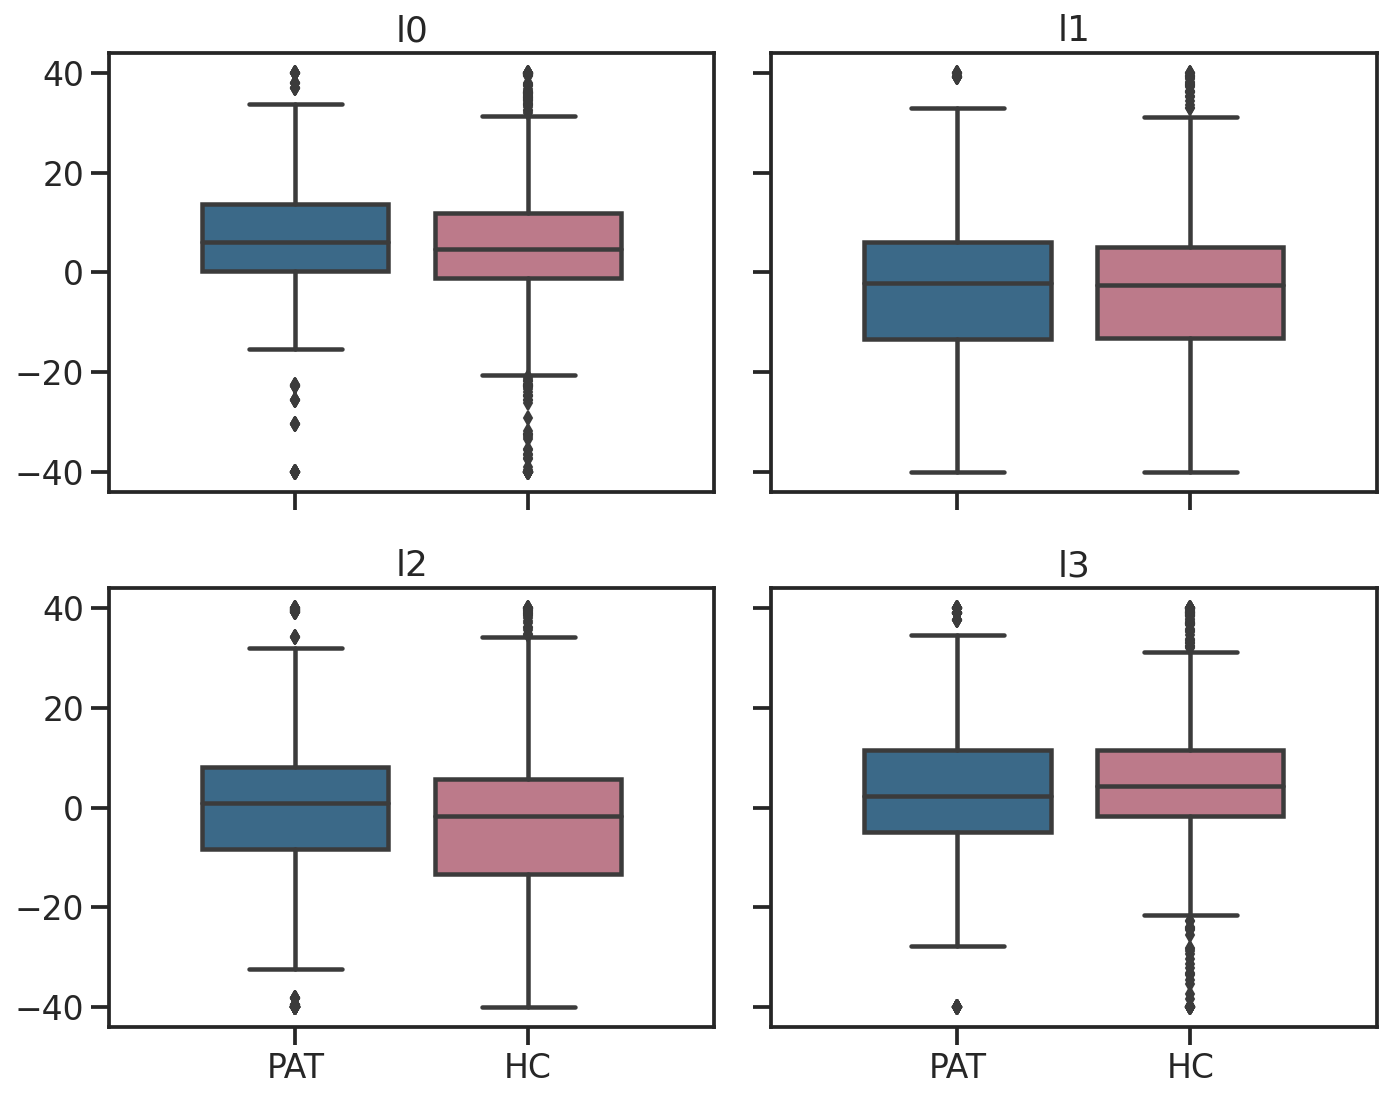

In [9]:
tar = ['l0', 'l1', 'l2', 'l3']
nr, nc = 2, 2 
fix, axs = plt.subplots(nr, nc, figsize=(nc*5, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        sns.boxplot(x='group', y=f'{tar[idx]}', data=for_analyze,
                        palette=viz.Palette, ax=ax)
        ax.set_xlim([-.8, 1.8])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(tar[idx])

plt.tight_layout()

## 3. Exclude data in experiment 2

In [10]:
## load data and concat the data
agent = 'mix_pol'
gain_data = pd.read_csv(f'../simulations/{agent}/sim_gain_data-idx0.csv').query('exp_id=="exp1"')
loss_data = pd.read_csv(f'../simulations/{agent}/sim_loss_data-idx0.csv').query('exp_id=="exp1"')

In [11]:
pivot_tables = get_pivot(gain_data, loss_data)
datainfo(pivot_tables)


        #subjects: 342

        #gain tasks: 170
        #loss tasks: 172

        #patient tasks: 130
        #control tasks: 212
       
        #patient gain tasks: 64
        #patient loss tasks: 66
        #control gain tasks: 106
        #control loss tasks: 106
       


In [12]:
n = 106
pivot_tables['gain, PAT'] = bootstrapping(pivot_tables['gain, PAT'], size=n)
pivot_tables['loss, PAT'] = bootstrapping(pivot_tables['loss, PAT'], size=n)
datainfo(pivot_tables)


        #subjects: 424

        #gain tasks: 212
        #loss tasks: 212

        #patient tasks: 212
        #control tasks: 212
       
        #patient gain tasks: 106
        #patient loss tasks: 106
        #control gain tasks: 106
        #control loss tasks: 106
       


In [13]:
## combine the tables for analyze 
for_analyze = [pivot_tables[k] for k in pivot_tables.keys()]
for_analyze = pd.concat(for_analyze, axis=0, ignore_index=True)

### Replication

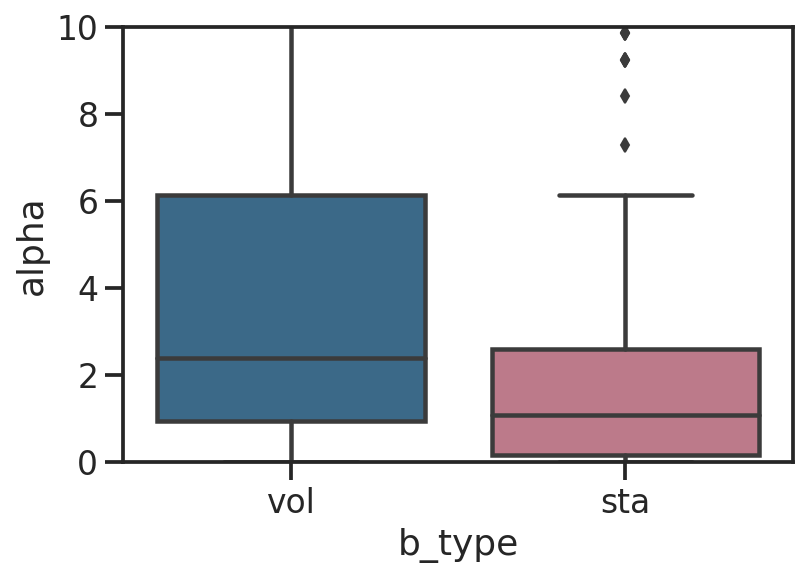

In [14]:
fig, ax = plt.subplots(1,1)
sns.boxplot(x='b_type', y='alpha', data=for_analyze,
                        palette=viz.Palette, ax=ax)
plt.ylim(0,10)
plt.show()

### The main effect

We use the one-way ANOVA for significant test (the same as Browning, 2015).

In [36]:
def sig_test(cond1, cond2, ws=['l0', 'l1', 'l2', 'l3']):
    ## the significant test 
    for w in ws:
        x = for_analyze.query(cond1)[w].values
        y = for_analyze.query(cond2)[w].values
        res = f_oneway(x, y)
        print(f'{w}: f={res[0]:.4f}, p<.5:{res[1]<.5}, p<.01:{res[1]<.01}')

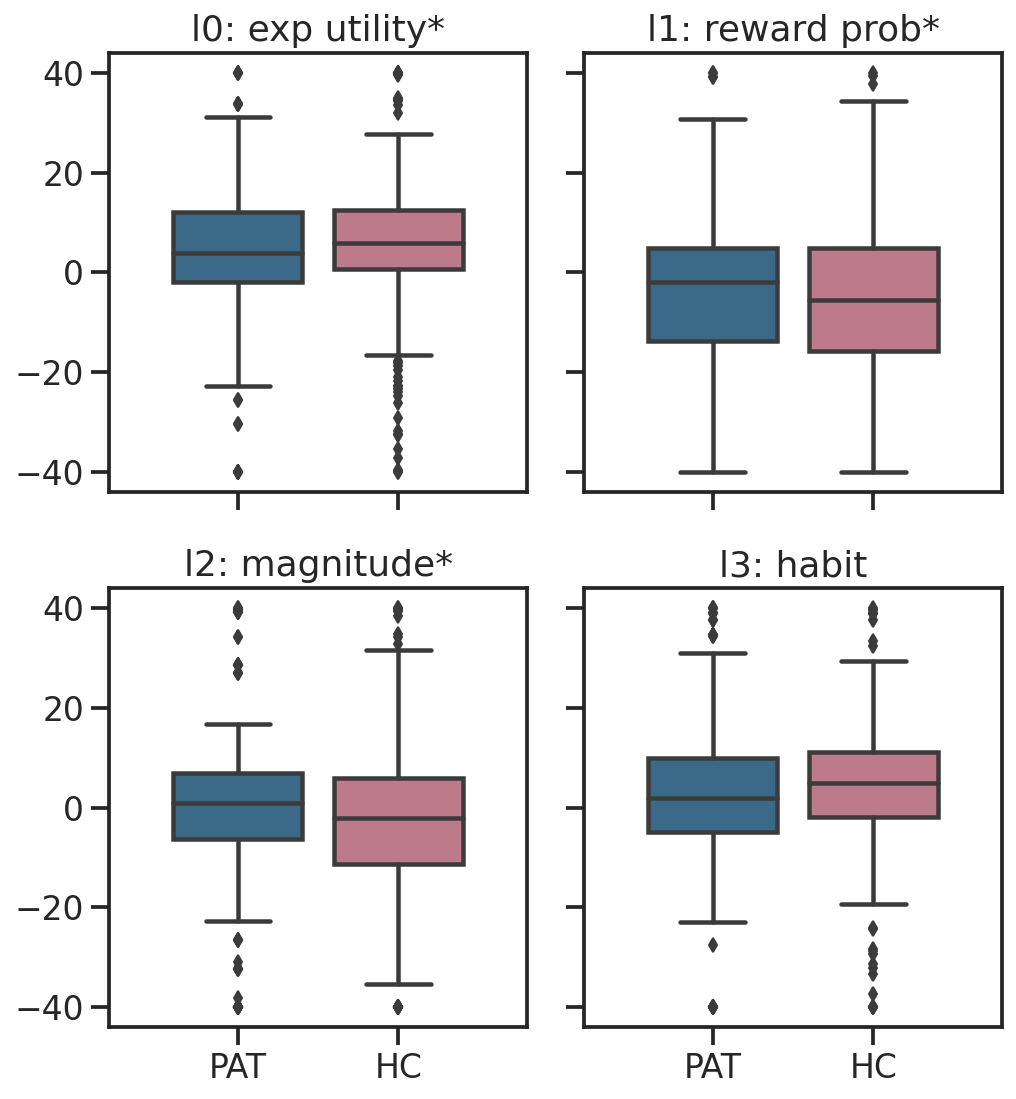

In [27]:
## Paitent V.S. healthy control 

tar = ['l0', 'l1', 'l2', 'l3']
notes = ['exp utility*', 'reward prob*', 'magnitude*', 'habit']
nr, nc = 2, 2 
fig, axs = plt.subplots(nr, nc, figsize=(nc*3.7, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        sns.boxplot(x='group', y=f'{tar[idx]}', data=for_analyze,
                        palette=viz.Palette, ax=ax)
        ax.set_xlim([-.8, 1.8])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(f'{tar[idx]}: {notes[idx]}')
        # if idx == 1: ax.legend(bbox_to_anchor=(1.4, 0), loc='lower right')
        # else: ax.get_legend().remove()
        
plt.tight_layout()

In [17]:
sig_test('group=="HC"', 'group!="HC"')

l0: f=0.5150, p<.5:True, p<.01:False
l1: f=0.9119, p<.5:True, p<.01:False
l2: f=2.0919, p<.5:True, p<.01:False
l3: f=0.0135, p<.5:False, p<.01:False


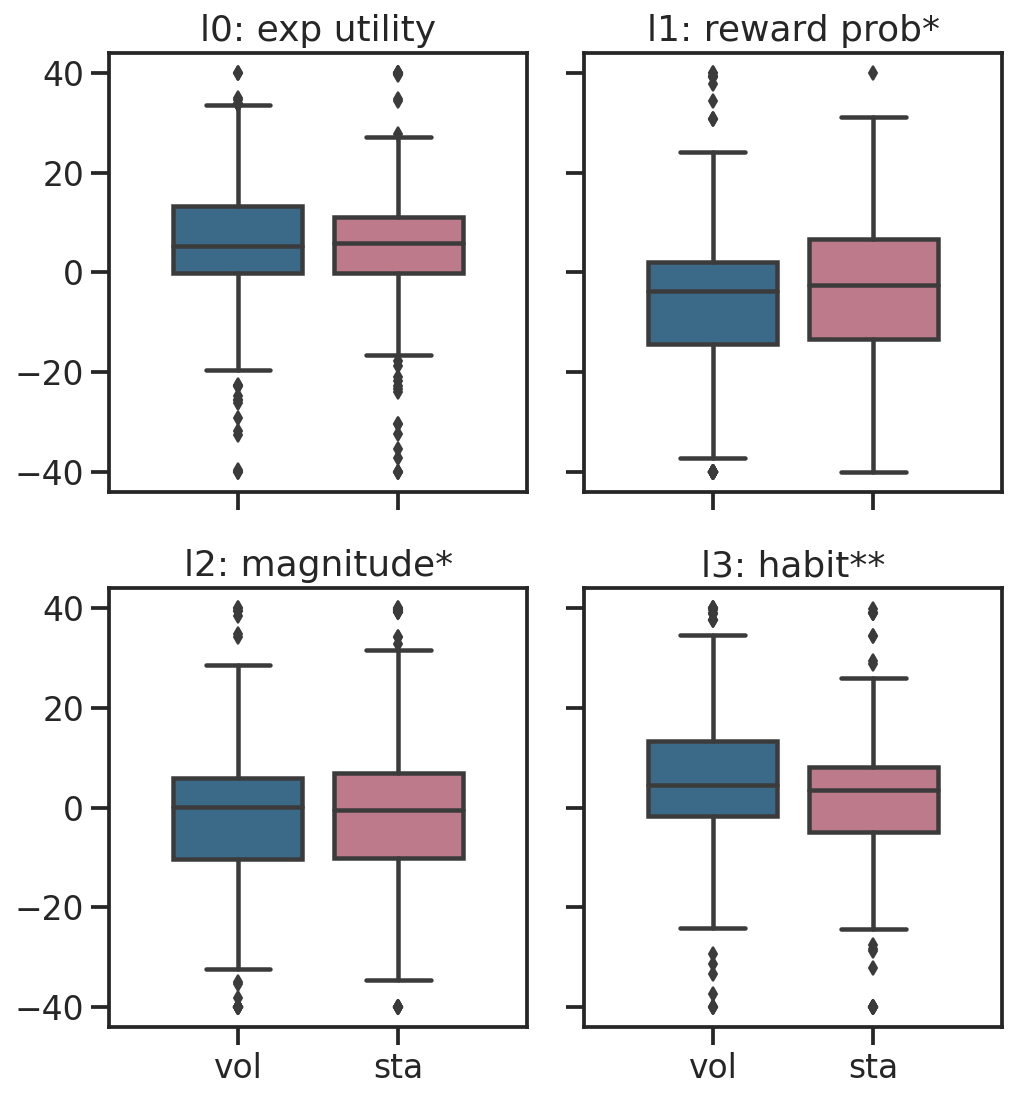

In [28]:
## Stable v.s. Volatile 

tar = ['l0', 'l1', 'l2', 'l3']
notes = ['exp utility', 'reward prob*', 'magnitude*', 'habit**']
nr, nc = 2, 2 
fig, axs = plt.subplots(nr, nc, figsize=(nc*3.7, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        sns.boxplot(x='b_type', y=f'{tar[idx]}', data=for_analyze,
                        palette=viz.Palette, ax=ax)
        ax.set_xlim([-.8, 1.8])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(f'{tar[idx]}: {notes[idx]}')
        # if idx == 1: ax.legend(bbox_to_anchor=(1.4, 0), loc='lower right')
        # else: ax.get_legend().remove()
        
plt.tight_layout()

In [29]:
sig_test('b_type=="vol"', 'b_type=="sta"')

l0: f=0.2465, p<.5:False, p<.01:False
l1: f=1.4662, p<.5:True, p<.01:False
l2: f=0.5807, p<.5:True, p<.01:False
l3: f=9.1459, p<.5:True, p<.01:True


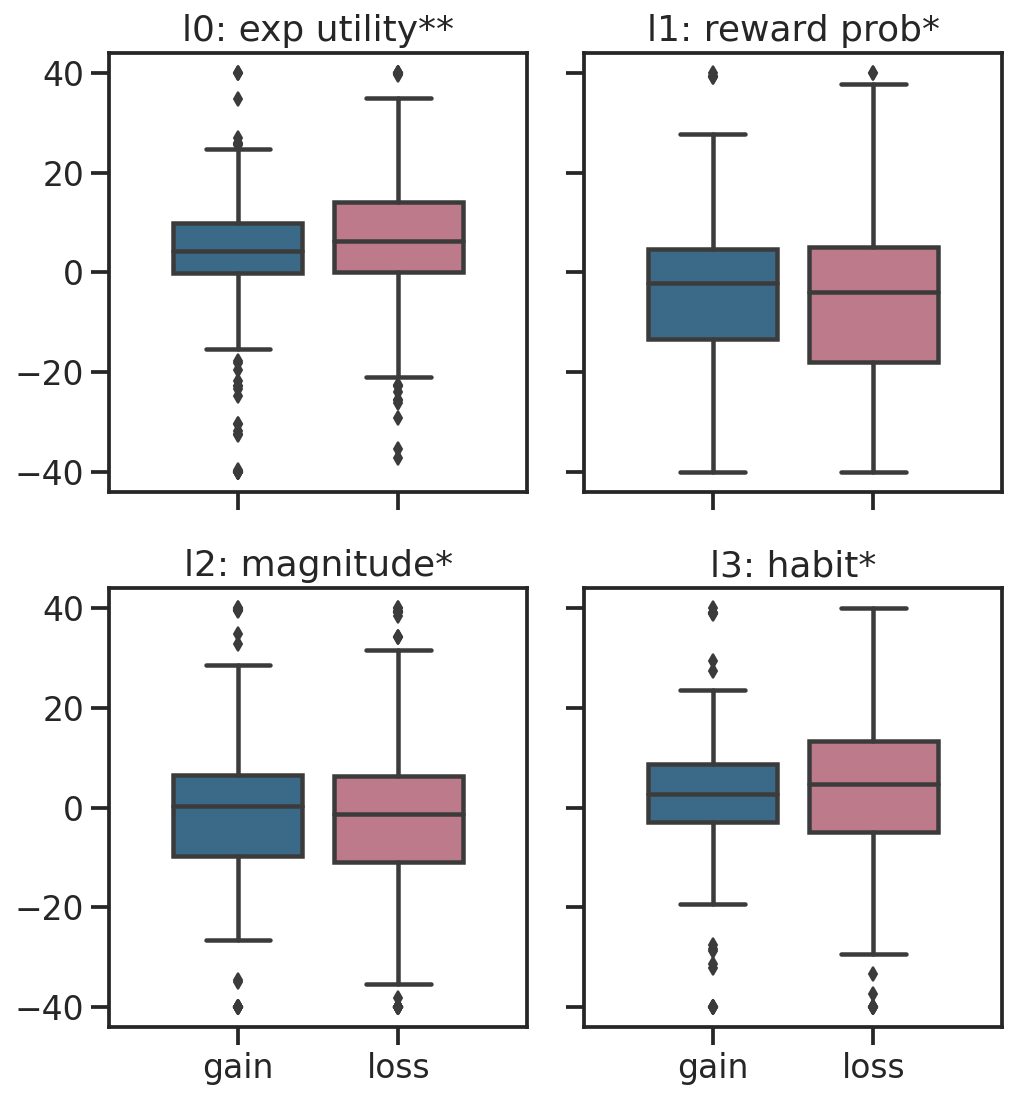

In [30]:
## Gain v.s. Loss
tar = ['l0', 'l1', 'l2', 'l3']
notes = ['exp utility**', 'reward prob*', 'magnitude*', 'habit*']
nr, nc = 2, 2 
fig, axs = plt.subplots(nr, nc, figsize=(nc*3.7, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        sns.boxplot(x='feedback_type', y=f'{tar[idx]}', data=for_analyze,
                        palette=viz.Palette, ax=ax)
        ax.set_xlim([-.8, 1.8])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(f'{tar[idx]}: {notes[idx]}')
        # if idx == 1: ax.legend(bbox_to_anchor=(1.4, 0), loc='lower right')
        # else: ax.get_legend().remove()
        
plt.tight_layout()

In [31]:
sig_test('feedback_type=="gain"', 'feedback_type=="loss"')

l0: f=9.3906, p<.5:True, p<.01:True
l1: f=1.4898, p<.5:True, p<.01:False
l2: f=1.1624, p<.5:True, p<.01:False
l3: f=2.0484, p<.5:True, p<.01:False


### Intersection effect: block_type X group

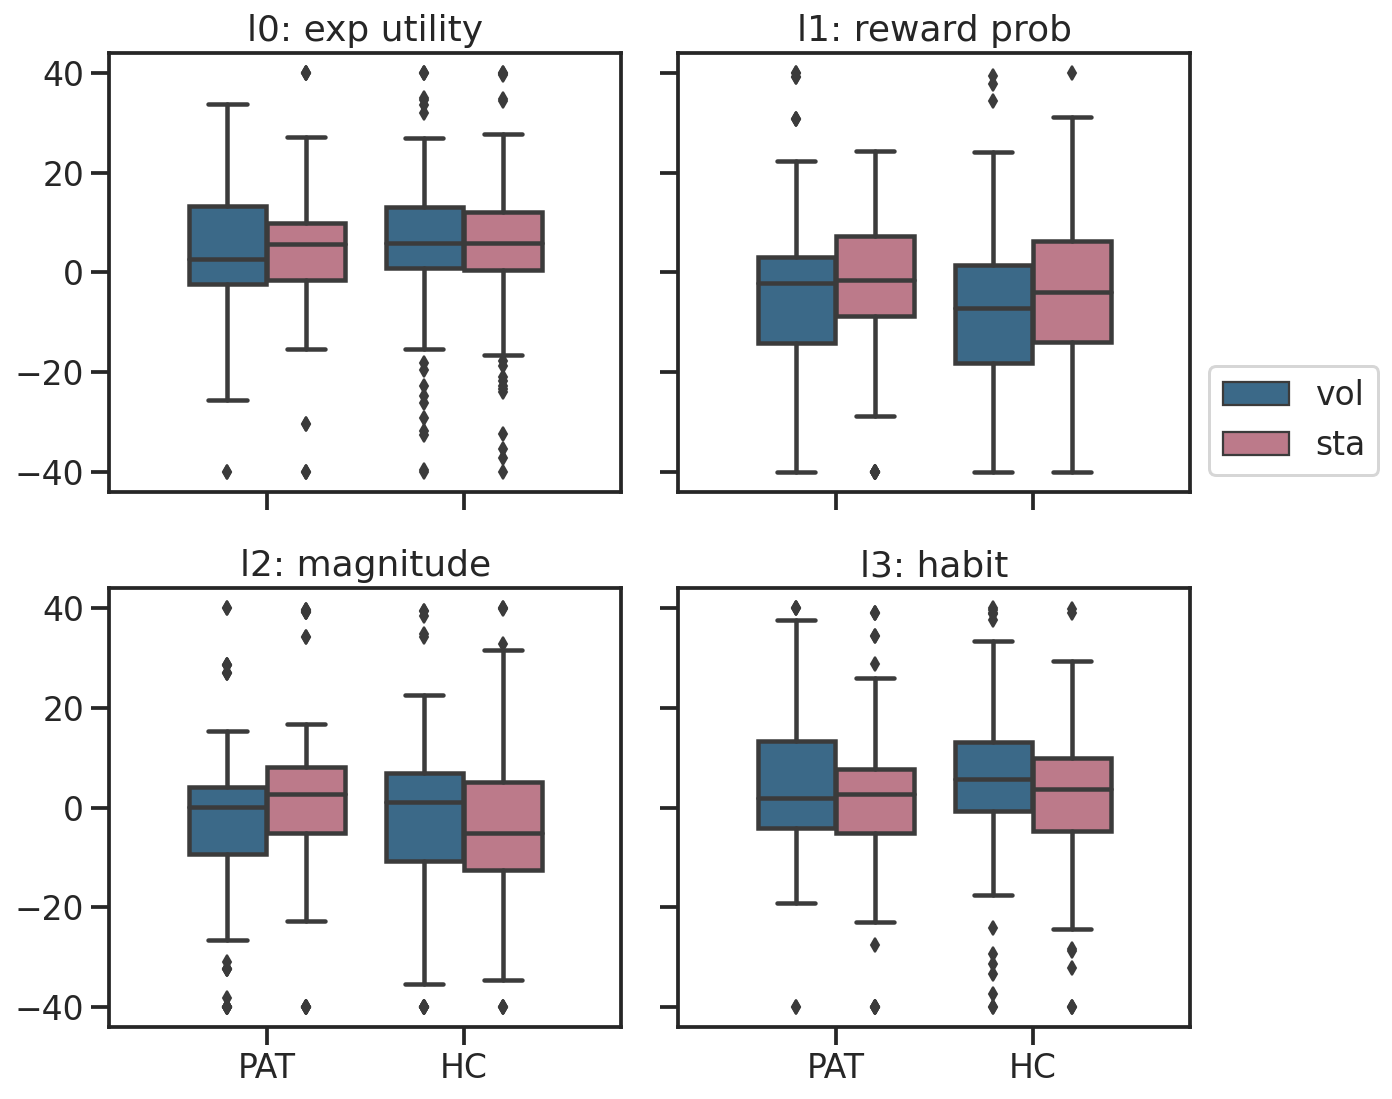

In [24]:
tar = ['l0', 'l1', 'l2', 'l3']
nr, nc = 2, 2 
fig, axs = plt.subplots(nr, nc, figsize=(nc*5, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        sns.boxplot(x='group', y=f'{tar[idx]}', data=for_analyze,
                        hue='b_type', 
                        palette=viz.Palette, ax=ax)
        ax.set_xlim([-.8, 1.8])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(f'{tar[idx]}: {notes[idx]}')
        if idx == 1: ax.legend(bbox_to_anchor=(1.4, 0), loc='lower right')
        else: ax.get_legend().remove()
        

plt.tight_layout()

In [25]:
sig_test('group!="HC" & b_type=="vol"', 'group!="HC" & b_type=="sta"')

l0: f=0.0799, p<.5:False, p<.01:False
l1: f=0.0166, p<.5:False, p<.01:False
l2: f=4.8562, p<.5:True, p<.01:False
l3: f=7.0137, p<.5:True, p<.01:True


In [26]:
sig_test('group=="HC" & b_type=="vol"', 'group=="HC" & b_type=="sta"')

l0: f=0.2078, p<.5:False, p<.01:False
l1: f=2.8020, p<.5:True, p<.01:False
l2: f=1.2211, p<.5:True, p<.01:False
l3: f=2.5989, p<.5:True, p<.01:False


## 4. Remove: reward probability

In [33]:
## load data and concat the data
agent = 'mix_pol_3w'
gain_data = pd.read_csv(f'../simulations/{agent}/sim_gain_exp1data-idx0.csv')
loss_data = pd.read_csv(f'../simulations/{agent}/sim_loss_exp1data-idx0.csv')
pivot_tables = get_pivot(gain_data, loss_data, features=['rew', 'match', 'alpha', 'l0', 'l1', 'l2'])
n = 106
pivot_tables['gain, PAT'] = bootstrapping(pivot_tables['gain, PAT'], size=n)
pivot_tables['loss, PAT'] = bootstrapping(pivot_tables['loss, PAT'], size=n)
datainfo(pivot_tables)
## combine the tables for analyze 
for_analyze = [pivot_tables[k] for k in pivot_tables.keys()]
for_analyze = pd.concat(for_analyze, axis=0, ignore_index=True)


        #subjects: 424

        #gain tasks: 212
        #loss tasks: 212

        #patient tasks: 212
        #control tasks: 212
       
        #patient gain tasks: 106
        #patient loss tasks: 106
        #control gain tasks: 106
        #control loss tasks: 106
       


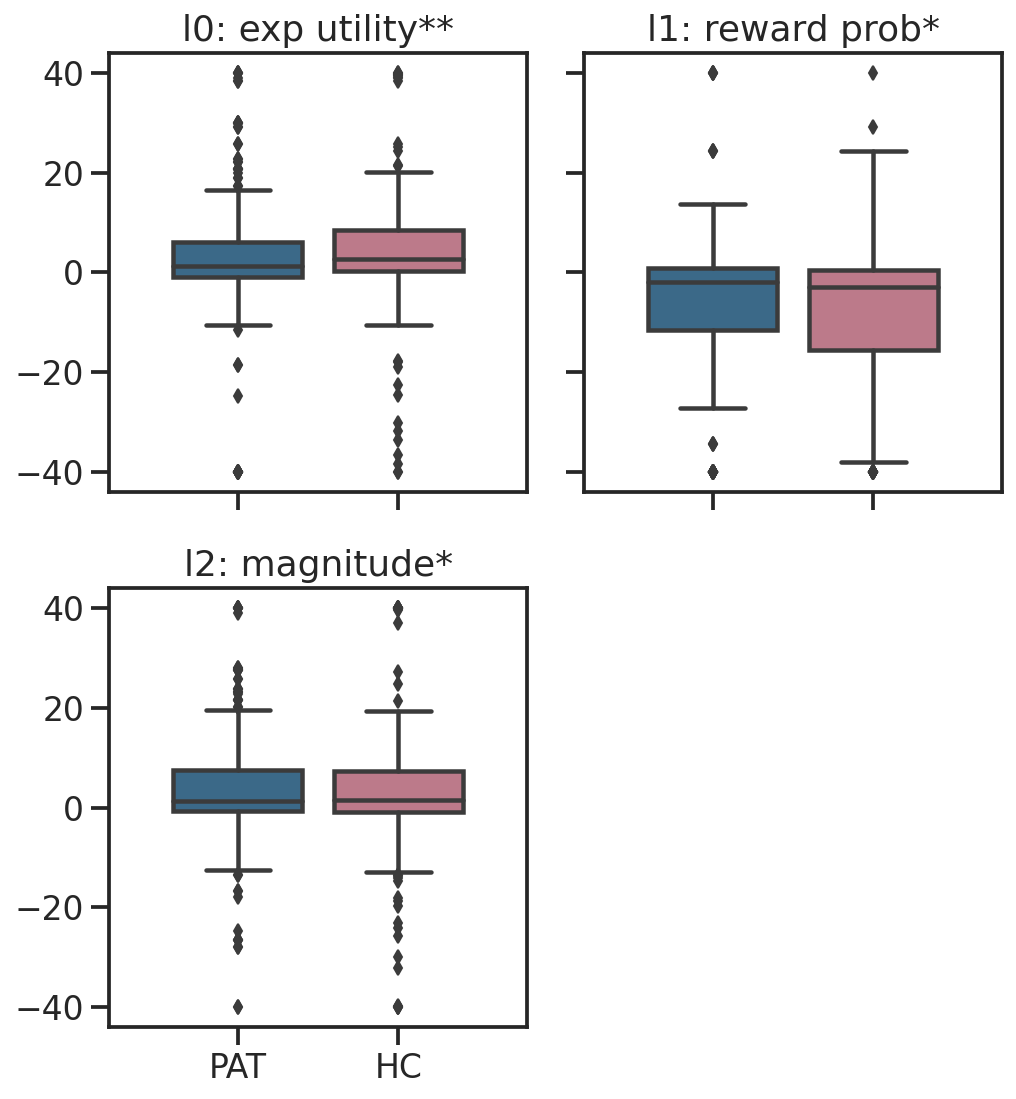

In [34]:
## Gain v.s. Loss
tar = ['l0', 'l1', 'l2']
nr, nc = 2, 2 
fig, axs = plt.subplots(nr, nc, figsize=(nc*3.7, nr*4), sharey=True, sharex=True)
for i in range(nr):
    for j in range(nc):
        ax  = axs[i, j]
        idx = i*nc + j 
        if idx < len(tar):
            sns.boxplot(x='group', y=f'{tar[idx]}', data=for_analyze,
                            palette=viz.Palette, ax=ax)
            ax.set_xlim([-.8, 1.8])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title(f'{tar[idx]}: {notes[idx]}')
        else:
            ax.set_axis_off()
        # if idx == 1: ax.legend(bbox_to_anchor=(1.4, 0), loc='lower right')
        # else: ax.get_legend().remove()
        
plt.tight_layout()

In [37]:
sig_test('group=="PAT"', 'group=="HC"', ws=['l0', 'l1', 'l2'])

l0: f=1.8021, p<.5:True, p<.01:False
l1: f=0.8292, p<.5:True, p<.01:False
l2: f=0.4981, p<.5:True, p<.01:False


### Paper structure

1. Gagne's paper thoroughly analyzed the learning rate without examining the policy. The main reason is that the best fit model is built in a hardly intuitively understandable way. Here, we claimed the best fit model is merely a mixture of several response strategies. We arranged the model and applied it to reveal the individual difference. 
    
    Possible concern: Remember to compare the risk preference model proposed in Brehens, 2007;

    * If the risk preference model fits terrible, it is easy to defend our model
    * If the risk preference model better fits the data, one possible way to defend our model is that the model does not explain the systematic difference between the performance of the health control and patients. <br><br>

2. Derive the new model from Gagne's model (method) and show that they are similar using model-fitting evidence (Result: similar fit, replicate the higher learning rate for volatile task).

    Luckily, the new model fits slightly better than Gagne's model.  

3. Apply the model to reveal the systematic different response strategies for various conditions (patient or not, volatile or stable, gain or loss). Explain the different through cognitive effort. From $w_1 \rightarrow w_4$, the strategies become less cognitive demanding. 

    Open question: is there any formal way to evaluate the degree of cognitive demanding.